In [1]:
"""
Author: Callum Davidson
Published: 7/11/22
"""

import numpy as np       
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import flexpolyline as fp
import os
import requests
import json
from datetime import datetime
import cartopy.geodesic as cgeo
from matplotlib import cm 
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from plothere import *

In [2]:
__hereKey__ = os.environ['__HERE_API_KEY__'] # in format '=1a2B3C4....'

# Search and Isoline parameters
location_search = 'christchurch new zealand' # Search string to find the origin/destintion of isolines
ranges = np.array([5,10,15,30])*60 # Isoline range values in minutes
range_type = 'time'
time = "July 6, 2022 5:00pm" # Start/arrival time

# Parse time string
parsed_time = datetime.strptime(time, "%B %d, %Y %I:%M%p")
parsed_time = parsed_time.isoformat()


print('Attempting to geocode: ' +location_search)

# Geocode location from HERE geocding API
loc = requests.get(here_geocode_request(location_search, __hereKey__)).json()

print('Top Result: '+ loc['items'][0]['title'])

# Pull out lat/lon coords from API response
origin = [loc['items'][0]['position']['lat'],loc['items'][0]['position']['lng']]

print('Requesting isolines... ', end='')

isoline_response = requests.get(here_isoline_request(origin, 'car', ranges, range_type, __hereKey__, parsed_time)).json()

try:
    len(isoline_response['isolines'])
    print('Success!')
except:
    print('Something has happened: Check key and permissions!')

# Convert to lat-lon coords
isolines = here_isolines_to_WGS84(isoline_response)

Attempting to geocode: christchurch new zealand
Top Result: Christchurch, Canterbury, New Zealand
Requesting isolines... Success!


C:\Users\callu\Downloads\isochrones-python-apis-master\isochrones-python-apis-master\plothere.py:220: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


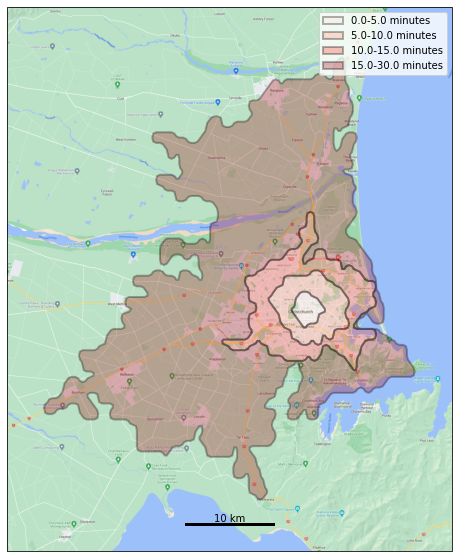

In [3]:
# Collect isoline vertices into numpy arrays
try: # For multiple ranges
    polygons = [np.hstack((np.vstack(isolines[value][:,1]), np.vstack(isolines[value][:,0]))) for value in ranges]
except: # For single range
    polygons = [np.hstack((np.vstack(isolines[ranges][:,1]), np.vstack(isolines[ranges][:,0])))]
    
basemap = cimgt.GoogleTiles()
fig, ax = plt.subplots(figsize=(10,10),
                       subplot_kw=dict(projection=basemap.crs))

extent = find_extent(polygons) # finds (xmin, xmax, ymin, ymax)
ax.set_extent(extent, crs=ccrs.Geodetic())

map_zoom = 12 # adjust as neccesary
ax.add_image(basemap, map_zoom)

cmap=cm.get_cmap('Reds_r') # colormap for isoline levels

plot_isolines(isolines, ax,label_rounding=0, cmap = cmap, contour_lines=2)

ax.legend(loc='best')
scale_bar(ax) # Add scale bar

# Save figure, this just has a unecessarily long but automated title format, change as you like
plt.savefig(loc['items'][0]['title'].replace(',','_').replace(' ','')+'_'+parsed_time[:16].replace('T','-').replace(':','')+'.png',dpi=300)